## 설정 

In [1]:
# upload the kaggle token
from google.colab import files
kaggle_token = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# download kaggle datasets by kaggle API
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d vivek468/superstore-dataset-final
!unzip -q /content/superstore-dataset-final.zip

100% 550k/550k [00:00<00:00, 1.30MB/s]
100% 550k/550k [00:00<00:00, 1.30MB/s]


In [3]:
# install libraries needed

!pip install datasets
!pip install transformers
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 14.3 MB/s 
     |████████████████████████████████| 182 kB 59.9 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 132 kB 62.1 MB/s 
     |████████████████████████████████| 127 kB 79.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 10.2 MB/s 
     |████████████████████████████████| 7.6 MB 48.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 12.3 MB/s 
  Created wheel for umap

## 데이터 전처리 

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# import the data
df = pd.read_csv('Sample - Superstore.csv',
                 encoding='windows-1252')

In [18]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [19]:
df.columns, df.shape

(Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
        'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
       dtype='object'), (9994, 21))

In [20]:
# Hackathon-like shaping
df = df[['Product Name', 'Sales', 'Category', 'Sub-Category']]

In [21]:
df.isnull().sum()

Product Name    0
Sales           0
Category        0
Sub-Category    0
dtype: int64

In [22]:
for category in df['Category'].unique():
  category_df = df[df['Category']==category]['Sub-Category']
  print(f'category={category}, {category_df.nunique()}, {category_df.unique()}\n')

category=Furniture, 4, ['Bookcases' 'Chairs' 'Tables' 'Furnishings']

category=Office Supplies, 9, ['Labels' 'Storage' 'Art' 'Binders' 'Appliances' 'Paper' 'Envelopes'
 'Fasteners' 'Supplies']

category=Technology, 4, ['Phones' 'Accessories' 'Machines' 'Copiers']



서브카테고리가 카테고리별로 중복이 없으므로, 타겟은 서브카테고리로 잡고, 카테고리는 서브카테고리가 뭐냐에 따라 if문으로 단순히 나누겠습니다.

프리트레인 모델은 분류모델에 좋은 BERT쪽 distilbert 모델을 사용하겠습니다. 

In [23]:
# drop
categories = df['Category'].unique()
df.drop(columns='Category', inplace=True)
df.rename(columns={'Sub-Category':'label'}, inplace=True)

In [24]:
df.head()

,Product Name,Sales,label
0,Bush Somerset Collection Bookcase,261.9600,Bookcases
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,Chairs
2,Self-Adhesive Address Labels for Typewriters b...,14.6200,Labels
3,Bretford CR4500 Series Slim Rectangular Table,957.5775,Tables
4,Eldon Fold 'N Roll Cart System,22.3680,Storage


In [25]:
# train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])

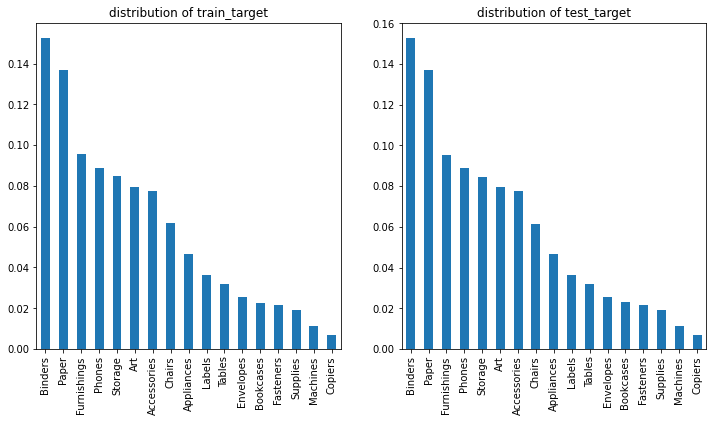

In [26]:
# check the result of split
f, ax = plt.subplots(1, 2, figsize=(12, 6))
train['label'].value_counts(normalize=True).plot.bar(ax=ax[0])
ax[0].set_title('distribution of train_target')
test['label'].value_counts(normalize=True).plot.bar(ax=ax[1])
ax[1].set_title('distribution of test_target')
plt.show()

In [27]:
# convert pd.DataFrame to datasets.DatasetDict
import datasets

train_dataset = datasets.Dataset.from_dict(train)
test_dataset = datasets.Dataset.from_dict(test)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Product Name', 'Sales', 'label'],
        num_rows: 7995
    })
    test: Dataset({
        features: ['Product Name', 'Sales', 'label'],
        num_rows: 1999
    })
})

## 토크나이징

In [29]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

In [30]:
pretrained_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# 프리트레인 모델에 사용했던 토크나이저를 가져오는 AutoTokenizer 라이브러리를 사용합니다

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [31]:
# func definition for tokenizing
def tokenize(batch):
	return tokenizer(batch['Product Name'], padding=True, truncation=True)

In [32]:
# tokenizing apply
dataset_tokenized = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
# check the results of tokenizing
dataset_tokenized['train']['input_ids'][1], dataset_tokenized['train']['attention_mask'][1]

(tensor([  101, 28052,  4090,  2581,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## 모델링 

In [34]:
from transformers import AutoModel

In [35]:
# set the model and device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
model = AutoModel.from_pretrained(pretrained_model).to(device)

#마찬가지로, 프리트레인모델의 모델을 자동으로 불러오는 AutoModel 라이브러리를 사용

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# A function that outputs a hidden layer by adding dataset_tokenized to the model
def extract_hidden_states(batch):
	inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
	with torch.no_grad():
		last_hidden_state = model(**inputs).last_hidden_state

	return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [37]:
# Convert to Tensor form for input of model
dataset_tokenized.set_format('torch',
                             columns=['input_ids', 'attention_mask', 'label'])

In [38]:
# Hidden layer output
dataset_hidden = dataset_tokenized.map(extract_hidden_states, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [39]:
dataset_hidden

DatasetDict({
    train: Dataset({
        features: ['Product Name', 'Sales', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 7995
    })
    test: Dataset({
        features: ['Product Name', 'Sales', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1999
    })
})

## 모델 학습 전, 은닉층 시각화 해보기기

In [40]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [41]:
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_test = np.array(dataset_hidden['test']['hidden_state'])
y_train = np.array(dataset_hidden['train']['label'])
y_test = np.array(dataset_hidden['test']['label'])

# 시각화를 위해 넘파이 배열로 변환 (은닉층 데이터세트가 넘파이가 되었으니, 여기서부터는 배워왔던 ML 머신들을 사용할 수 있습니다)

In [42]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

# 2차원으로 차원을 축소하여 시각화하는 umap 알고리즘을 적용합니다 

/usr/local/lib/python3.8/dist-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [43]:
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head(3)

# umap 알고리즘을 적용한 결과를 dataframe으로 변환합니다

,X,Y,label
0,-12.141533,9.258744,Chairs
1,-18.058455,2.341671,Art
2,-10.179342,11.151248,Tables


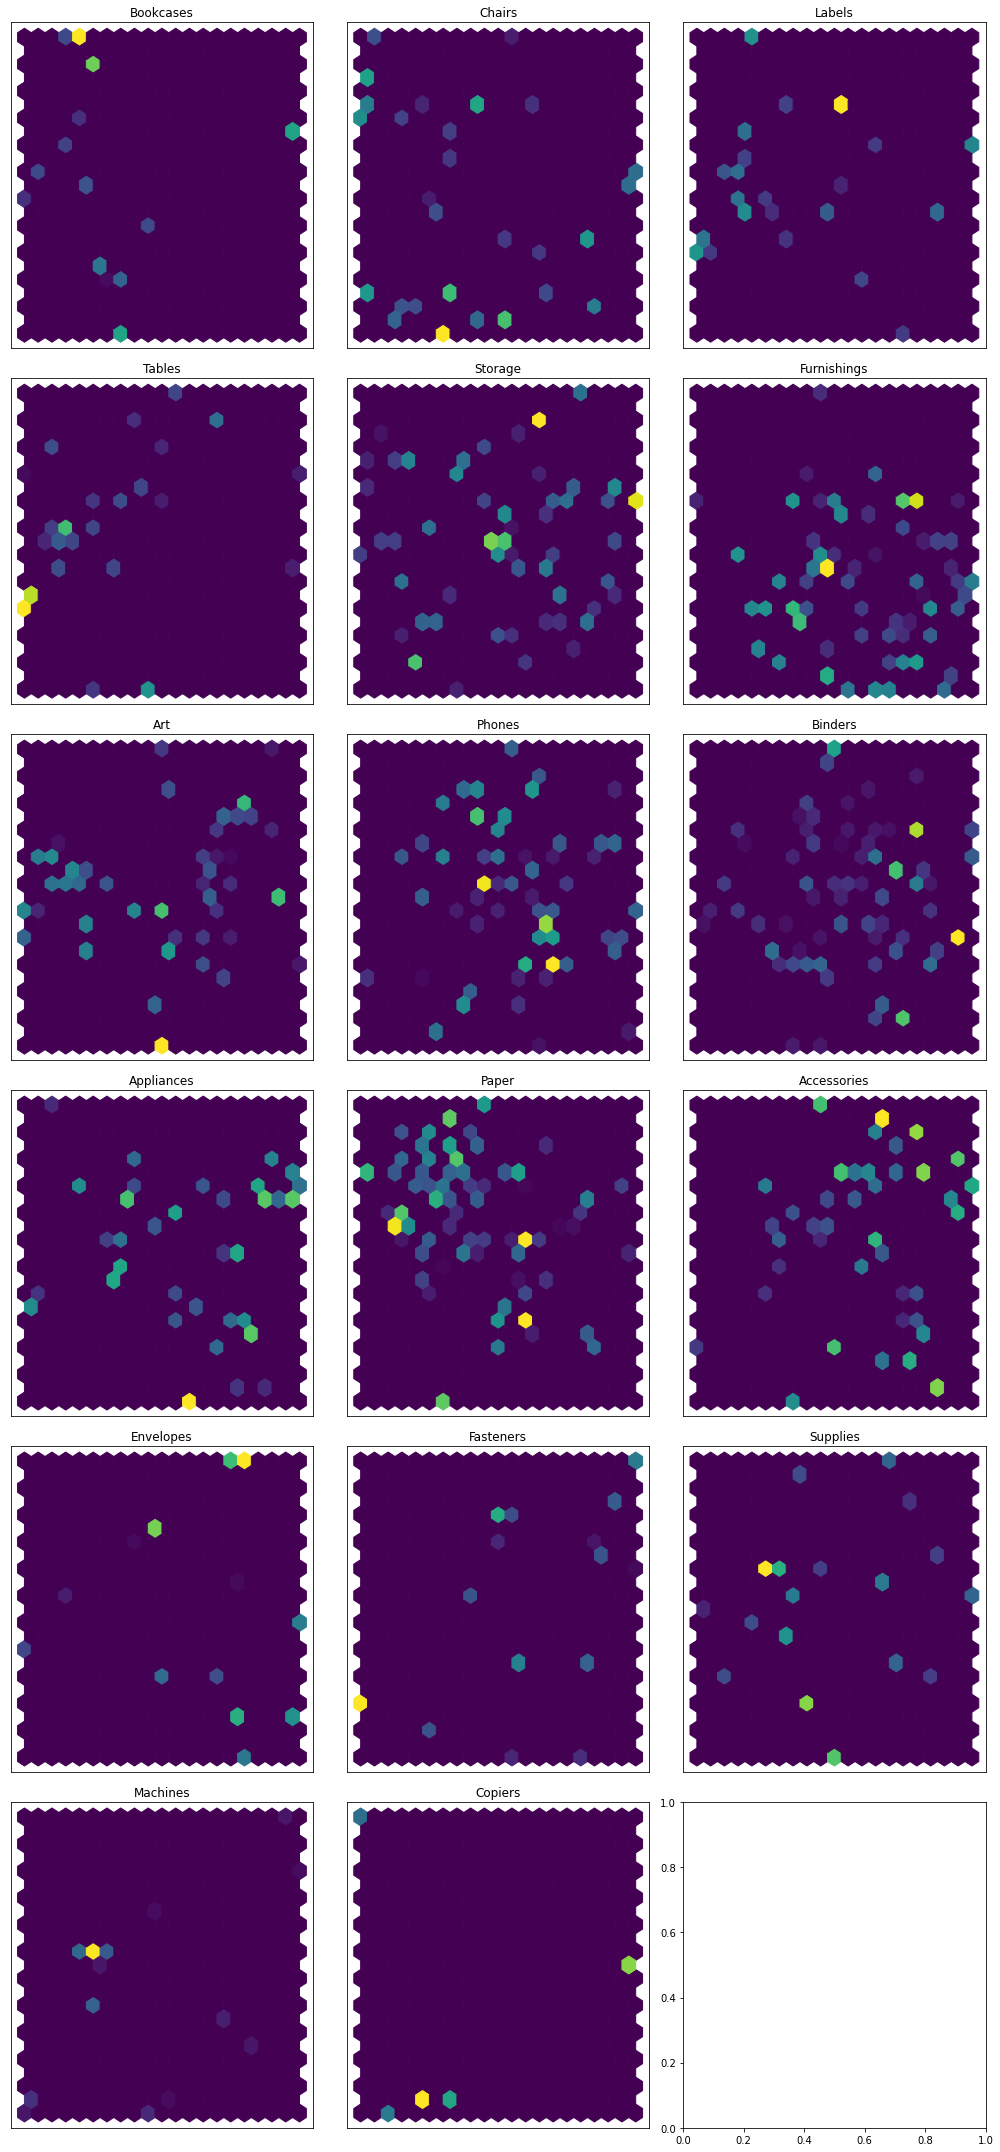

In [44]:
f, ax = plt.subplots(6, 3, figsize=(14, 30))
ax = ax.flatten()
cmaps = ['Blue', 'Orange, Purples']
labels = df['label'].unique()

for i, label in enumerate(labels):
  df_emb_sub = df_emb[df_emb['label'] == label]
  ax[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], gridsize=20)
  ax[i].set_title(label)
  ax[i].set_xticks([]), ax[i].set_yticks([])

plt.tight_layout()
plt.show()

# 대부분의 훈련 데이터가 구분되는 경향을 보입니다. 성능이 좋게 나올 듯 합니다.

## 모델 훈련 

In [45]:
# func def for hidden_states
def extract_hidden_states(batch):
	inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
	with torch.no_grad():
		last_hidden_state = model(**inputs).last_hidden_state

	return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [48]:
# Logisitic Regressor for baseline model
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

# 로지스틱 회귀모델만 써도 충분한 결과를 보여줍니다

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.991495747873937